# KANs efficiency

In questo notebook introduciamo le Kolmogorov-Arnold Network (KAN), e cerchiamo di risolvere alcuni problemi di regressione utilizzando sia le MLP, sia le KAN, per determinare quale fra questi due modelli sia il più efficiente.

In particolare, tentiamo di fittare funzioni reali a due variabili reali, così da utilizzare KAN standard con architettura $[2,5,1]$, che sono quelle introdotte nell'articolo di Ziming Liu.

Consideriamo funzioni da fittare a due variabili di complessità crescente, e in particolare studiamo tre casi:

1. $\,\,f(x,y) = x+y$
2. $\,\,g(x,y) = 1+x^2+y^4$
3. $\,\,h(x,y) = \exp\Big(\sin(\pi x)+y^2\Big)$

così da determinare se risulta più conveniente utilizzare le MLP o le KAN per risolvere tali problemi di regressione.

Osserviamo che queste funzioni sono tutte continue in $\mathbb{R}^2$: questo per soddisfare il teorema di rappresentazione di Kolmogorov-Arnold. Per fittare tali funzioni consideriamo in tutte e tre i casi 3000 elementi nel training set e 200 elementi sia nel validation set che nel test set. Il validation set servirà per monitorare l'andamento della validation loss function, assicurandosi che non si abbia overlearning, mentre il test set servirà per valutare l'accuratezza del modello.

Utilizzeremo i dati nel seguente insieme chiuso e limitato, sempre per soddisfare il teorema di rappresentazione: $x,y\in[-1,1]$.

Per determinare quale modello sia più conveniente utilizzare verranno considerati i seguenti fattori:

- Numero di parametri allenabili;
- Tempo di addestramento del modello;
- Loss function di validation raggiunta;
- Accuratezza nelle predizioni.

Come loss function per i modelli viene utilizzata la Root Mean Squared-Error (RMSE), determinata da
\begin{equation}
L = \sqrt{\frac{1}{N}\sum_{i=1}^N (y_i - \hat{y}_i)^2}\,\,\,,
\end{equation}
mentre per quantificare l'accuratezza nelle predizioni viene valutata la loss function (sempre la RMSE) sugli elementi del test set.

In particolare i modelli MLP verranno allenati finchè l'andamento della loss function di test non satura, prima che si arrivi dunque ad una situazione di overlearning, mentre i modelli KAN standard vengono allenati sempre in 50 epoche.

---

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from kan import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.optim as optim
import torch.nn as nn
import time

# Imposto il numero di thread a 1 per evitare conflitti con OpenMP
torch.set_num_threads(1)

In [2]:
# Impostazione dei semi per la riproducibilità
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

---

# Caso 1

Fittaimo la funzione $f(x,y)=x+y$.

Prima di tutto generiamo il dataset.

In [3]:
set_seed(42)

x_train = np.random.uniform(-1, 1, 3000)
y_train = np.random.uniform(-1, 1, 3000)
training_label = np.random.normal(x_train+y_train, 0.01)

x_validation = np.random.uniform(-1, 1, 200)
y_validation = np.random.uniform(-1, 1, 200)
validation_label = np.random.normal(x_validation+y_validation, 0.01)

x_test = np.random.uniform(-1, 1, 200)
y_test = np.random.uniform(-1, 1, 200)
# test_label = x_test + y_test
test_label = np.random.normal(x_test+y_test, 0.01)

# Combino x_train e y_train in un singolo array
training_data = np.column_stack((x_train, y_train))
validation_data = np.column_stack((x_validation, y_validation))
test_data = np.column_stack((x_test, y_test))

# Converto i dati in tensori PyTorch
training_data = torch.tensor(training_data, dtype=torch.float32)
training_label = torch.tensor(training_label, dtype=torch.float32).view(-1, 1)
validation_data = torch.tensor(validation_data, dtype=torch.float32)
validation_label = torch.tensor(validation_label, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32).view(-1, 1)

# Definisco il dizionario necessario per il training della KAN
dataset = {
    'train_input': training_data,
    'train_label': training_label,
    'test_input': validation_data,
    'test_label': validation_label
}

Definisco ora i modelli da utilizzareper fittare la funzione $f$: verrà utilizzata una MLP con un singolo hidden layer dotato di 10 neuroni, e una KAN standard avente due layer, con spline suddivise in 5 grid.

Alleno quindi i due modelli, misurando il tempo di addestarmento, la RMSE, e l'accuratezza di ognuno, e plottando l'andmento delle loss function di training e di validation (che corrsiponde a quella di test).

Addestramento della MLP
Early stopping all'epoca 1611
Numero di parametri allenabili: 41
Tempo di addestarmento: 1.16 s
Validation loss: 0.0104
Test loss: 0.0105


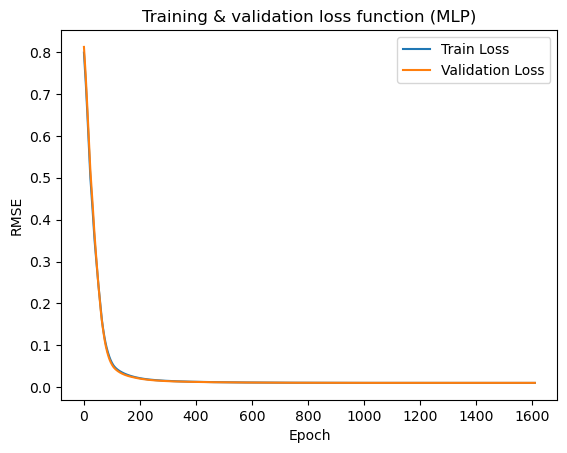

In [4]:
set_seed(42)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Funzione che restituisce il numero di parametri allenabili di una NN
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_mlp = MLP()

# Definisco l'ottimizzatore e la funzione di perdita
optimizer = optim.Adam(model_mlp.parameters(), lr=0.01)
criterion = nn.MSELoss()

num_epochs = 5000
patience = 20
best_loss = float('inf')
trigger_times = 0
epochs = []
train_losses = []
val_losses = []
test_losses = []
accuracies = []
r2_scores = []

print('Addestramento della MLP')

start_time = time.time()

# Addestramento della MLP
for epoch in range(num_epochs):
    epochs.append(epoch)
    model_mlp.train()
    optimizer.zero_grad()
    output = model_mlp(training_data)
    # Calcolo della training loss
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model_mlp.eval()
    with torch.no_grad():
        val_output = model_mlp(validation_data)
        test_output = model_mlp(test_data)
        # Calcolo della validation loss
        val_loss = criterion(val_output, validation_label)
        val_losses.append(val_loss.item())
        # Calcolo della test loss
        test_loss = criterion(test_output, test_label)
        test_losses.append(test_loss.item())

    # Implemento l'early stopping
    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping all'epoca {epoch}")
            break
        
end_time = time.time()

# Salvo e stampo i parametri, il training time, e le loss function
parameters_mlp = count_parameters(model_mlp)
training_time_mlp = end_time - start_time
validation_loss_mlp = np.sqrt(val_losses[-1])
test_loss_mlp = np.sqrt(test_losses[-1])

print(f'Numero di parametri allenabili: {int(parameters_mlp)}')
print(f'Tempo di addestarmento: {training_time_mlp:.2f} s')
print(f'Validation loss: {validation_loss_mlp:.4f}')
print(f'Test loss: {test_loss_mlp:.4f}')

# Plotto l'andamento delle loss function
plt.figure()
plt.plot(epochs, np.sqrt(train_losses), label='Train Loss')
plt.plot(epochs, np.sqrt(val_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training & validation loss function (MLP)')
plt.legend()
plt.show()

train loss: 1.01e-02 | test loss: 1.04e-02 | reg: 1.26e+01 : 100%|██| 50/50 [00:17<00:00,  2.83it/s]

Addestramento della KAN
Numero di parametri allenabili: 75
Tempo di addestarmento: 17.70 s
Validation loss: 0.0104
Test loss: 0.0104


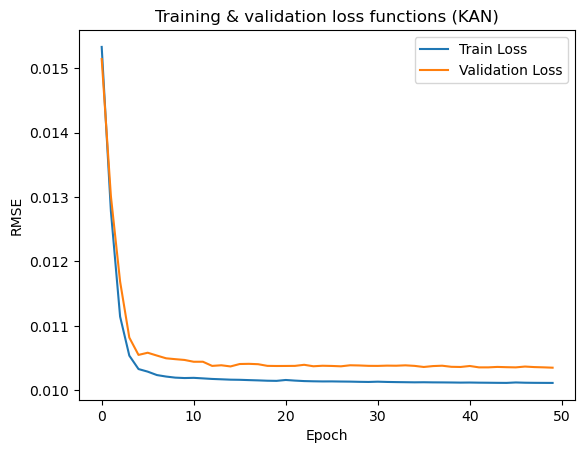

In [5]:
model_kan = KAN(width=[2,5,1], grid=5, k=3, seed=42)

start_time = time.time()

# Addestramento della KAN
steps = 50
results = model_kan.train(dataset, opt="LBFGS", steps=steps)

end_time = time.time()

# Salvo e stampo i parametri, il training time, la RMSE e l'accuratezza
parameters_kan = (2*5+5*1)*5
training_time_kan = end_time - start_time
validation_loss_kan = results['test_loss'][-1]
relative_error = torch.abs((model_kan(dataset['test_input']) - dataset['test_label']) / dataset['test_label'])
test_loss_kan = torch.sqrt(1/len(x_test) * torch.sum((model_kan(test_data) - test_label)**2))

print('Addestramento della KAN')
print(f'Numero di parametri allenabili: {int(parameters_kan)}')
print(f'Tempo di addestarmento: {training_time_kan:.2f} s')
print(f'Validation loss: {validation_loss_kan:.4f}')
print(f'Test loss: {test_loss_kan:.4f}')

# Plotto l'andamento delle loss function
plt.figure()
plt.plot(range(steps), results['train_loss'], label='Train Loss')
plt.plot(range(steps), results['test_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training & validation loss functions (KAN)')
plt.legend()
plt.show()

Plottiamo ora l'andamento della loss function di test del modello MLP, assieme alla test loss finale del modello KAN, che non può essere plottata, in quanto durante l'addestramento di quest'ultimo modello non si ha accesso alle predeizioni. Inoltre il numero di epoche per i due addestramenti è differente.

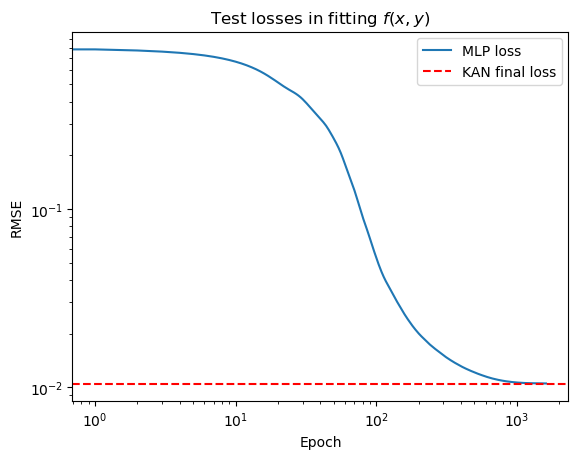

In [6]:
plt.figure()
plt.plot(epochs, np.sqrt(test_losses), label='MLP loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.axhline(test_loss_kan.detach().numpy(), color='red', linestyle='--', label='KAN final loss')
plt.title('Test losses in fitting $f(x,y)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('test_loss_f')
plt.show()

In questo caso notiamo come i due modelli arrivano entrambi ad un ottimo fitting della funzione, raggiungendo una test di loss molto simile.

Sebbene entrambi i modelli ragiungono lo stesso buon risultato, osserviamo come il modello MLP è migliore per tempo di addestramento e per numero di parametri allenabili.

Possiamo concludere che per un problema di regressione in cui la funzione da fittare risulta additiva e lineare nelle due variabili, allora entrambi i modelli possono essere utilizzati per ottenere un fitting adeguato, ma in overall è preferibile scegliere il modello MLP, rivelandosi un modello più "snello", e con minore tempo di addestramento.

---

## Caso 2

Fittiamo adesso la funzione $g(x,y)=1+x^2+y^4$. Questa funzione, proprio come $f$, è additiva nelle due variabili reali, ma non è lineare in queste. Determiniamo se anche in questo caso entrambi i modelli sono adeguati per fittare la funzione.

Costruisco il dataset.

In [7]:
set_seed(42)

x_train = np.random.uniform(-1, 1, 3000)
y_train = np.random.uniform(-1, 1, 3000)
training_label = np.random.normal(1 + x_train**2 + y_train**4, 0.01)

x_validation = np.random.uniform(-1, 1, 200)
y_validation = np.random.uniform(-1, 1, 200)
validation_label = np.random.normal(1 + x_validation**2 + y_validation**4, 0.01)

x_test = np.random.uniform(-1, 1, 200)
y_test = np.random.uniform(-1, 1, 200)
test_label = np.random.normal(1 + x_test**2 + y_test**4, 0.01)

# Combino x_train e y_train in un singolo array
training_data = np.column_stack((x_train, y_train))
validation_data = np.column_stack((x_validation, y_validation))
test_data = np.column_stack((x_test, y_test))

# Converto i dati in tensori PyTorch
training_data = torch.tensor(training_data, dtype=torch.float32)
training_label = torch.tensor(training_label, dtype=torch.float32).view(-1, 1)
validation_data = torch.tensor(validation_data, dtype=torch.float32)
validation_label = torch.tensor(validation_label, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32).view(-1, 1)

# Definisco il dizionario necessario per il training della KAN
dataset = {
    'train_input': training_data,
    'train_label': training_label,
    'test_input': validation_data,
    'test_label': validation_label
}

Definisco i modelli per fittare la funzione $g$: verrà utilizzata una MLP con due hidden layer aventi 20 neuroni ciascuno, e una KAN standard, sempre con due layer, e un grid di dimensione 5.

Anche qui definisco e alleno i due modelli, stampando i parametri allenabili, il tempo di addestramento, la RMSE, e l'accuratezza, e plottando l'andamento delle loss function.

Addestramento della MLP
Early stopping all'epoca 1934
Numero di parametri allenabili: 501
Tempo di addestarmento: 2.53 s
Validation loss: 0.0198
Test loss: 0.0170


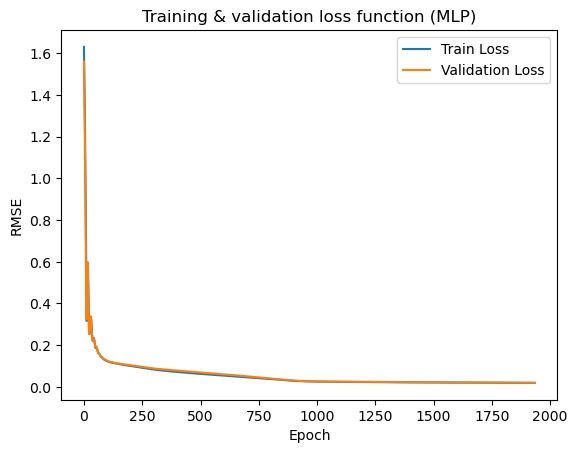

In [8]:
set_seed(42)

class MLP1(nn.Module):
    def __init__(self):
        super(MLP1, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Funzione che restituisce il numero di parametri allenabili di una NN
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_mlp = MLP1()

# Definisco l'ottimizzatore e la funzione di perdita
optimizer = optim.Adam(model_mlp.parameters(), lr=0.01)
criterion = nn.MSELoss()

num_epochs = 5000
patience = 20
best_loss = float('inf')
trigger_times = 0
epochs = []
train_losses = []
val_losses = []
test_losses = []
accuracies = []

print('Addestramento della MLP')

start_time = time.time()

# Addestramento della MLP
for epoch in range(num_epochs):
    epochs.append(epoch)
    model_mlp.train()
    optimizer.zero_grad()
    output = model_mlp(training_data)
    # Calcolo della training loss
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model_mlp.eval()
    with torch.no_grad():
        val_output = model_mlp(validation_data)
        test_output = model_mlp(test_data)
        # Calcolo della validation loss
        val_loss = criterion(val_output, validation_label)
        val_losses.append(val_loss.item())
        # Calcolo della test loss
        test_loss = criterion(test_output, test_label)
        test_losses.append(test_loss.item())

    # Implemento l'early stopping
    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping all'epoca {epoch}")
            break
        
end_time = time.time()

# Salvo e stampo i parametri, il training time, e le loss function
parameters_mlp = count_parameters(model_mlp)
training_time_mlp = end_time - start_time
validation_loss_mlp = np.sqrt(val_losses[-1])
test_loss_mlp = np.sqrt(test_losses[-1])

print(f'Numero di parametri allenabili: {int(parameters_mlp)}')
print(f'Tempo di addestarmento: {training_time_mlp:.2f} s')
print(f'Validation loss: {validation_loss_mlp:.4f}')
print(f'Test loss: {test_loss_mlp:.4f}')

# Plotto l'andamento delle loss function
plt.figure()
plt.plot(epochs, np.sqrt(train_losses), label='Train Loss')
plt.plot(epochs, np.sqrt(val_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training & validation loss function (MLP)')
plt.legend()
plt.show()

train loss: 1.01e-02 | test loss: 1.03e-02 | reg: 1.24e+01 : 100%|██| 50/50 [00:17<00:00,  2.86it/s]

Addestramento della KAN
Numero di parametri allenabili: 75
Tempo di addestarmento: 17.48 s
Validation loss: 0.0103
Test loss: 0.0105


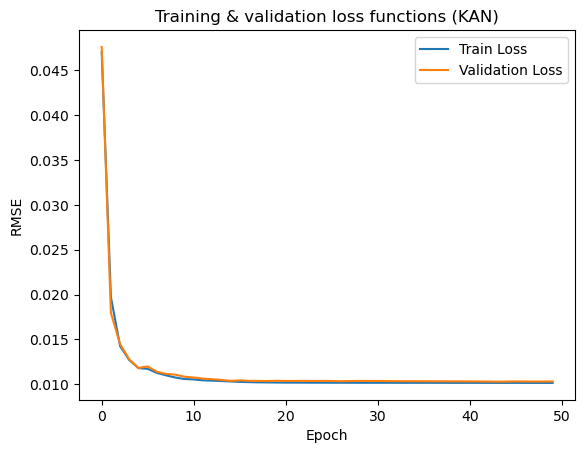

In [9]:
model_kan = KAN(width=[2,5,1], grid=5, k=3, seed=42)

start_time = time.time()

# Addestramento della KAN
steps = 50
results = model_kan.train(dataset, opt="LBFGS", steps=steps)

end_time = time.time()

# Salvo e stampo i parametri, il training time, la RMSE e l'accuratezza
parameters_kan = (2*5+5*1)*5
training_time_kan = end_time - start_time
validation_loss_kan = results['test_loss'][-1]
relative_error = torch.abs((model_kan(dataset['test_input']) - dataset['test_label']) / dataset['test_label'])
test_loss_kan = torch.sqrt(1/len(x_test) * torch.sum((model_kan(test_data) - test_label)**2))

print('Addestramento della KAN')
print(f'Numero di parametri allenabili: {int(parameters_kan)}')
print(f'Tempo di addestarmento: {training_time_kan:.2f} s')
print(f'Validation loss: {validation_loss_kan:.4f}')
print(f'Test loss: {test_loss_kan:.4f}')

# Plotto l'andamento delle loss function
plt.figure()
plt.plot(range(steps), results['train_loss'], label='Train Loss')
plt.plot(range(steps), results['test_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training & validation loss functions (KAN)')
plt.legend()
plt.show()

Plottiamo quindi l'andamento della loss functioin di test della MLP, e confrontiamolo con il valore della loss di test raggiunta dalla KAN.

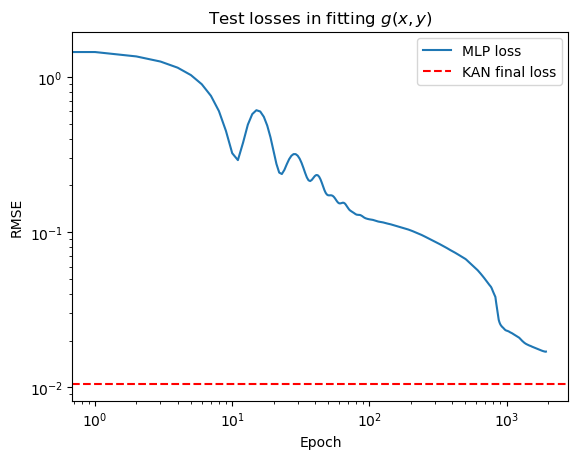

In [10]:
plt.figure()
plt.plot(epochs, np.sqrt(test_losses), label='MLP loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.axhline(test_loss_kan.detach().numpy(), color='red', linestyle='--', label='KAN final loss')
plt.title('Test losses in fitting $g(x,y)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('test_loss_g')
plt.show()

Anche in questo caso possiamo notare che entrambi i modelli raggiungono un buon fitting della funzione $g$.

Ossserviamo però che le predizioni effettuate dal modello determinato dalla KAN sono in questo caso migliori di quelle effettuate dal modello determinato dalla MLP. Notiamo inoltre come in questo caso il modello MLP comincia a diventare massivo, essendo che utilizza ben più di 500 parametri allenabili, mentre il modello KAN non supera i 100. Per quanto riguarda invece il tempo di addestramento, il modello MLP continua ad avere la meglio.

Constatiamo quindi che, per quanto riguarda problemi di regressione in cui si hanno funzioni a due variabili additive, ma non lineari in queste, si comincia riscontrare un vantaggio nell'utilizzo delle KAN: utilizzando queste ultime, ci si assicura un'ottima accuratezza nel fitting, pur utilizzando un modello dimensionalmente piccolo, ovvero che non supera i 100 parametri allenabili.

---

## Caso 3

Fittiamo adesso una funzione più complessa, ovvero la $\,\,h(x,y) = \exp\Big(\sin(\pi x)+y^2\Big)$, per verificare se l'accuratezza di fitting del modello KAN rimane ottima, pur utilizzando sempre la KAN standard, e quanti parametri allenabili sono determinati da un modello MLP per raggiungere un'accuratezza simile.

Anche in questo caso cominciamo generando e polttando il dataset.

In [11]:
set_seed(42)

x_train = np.random.uniform(-1, 1, 3000)
y_train = np.random.uniform(-1, 1, 3000)
training_label = np.random.normal(np.exp(np.sin(np.pi*x_train) + y_train**2), 0.01)

x_validation = np.random.uniform(-1, 1, 200)
y_validation = np.random.uniform(-1, 1, 200)
validation_label = np.random.normal(np.exp(np.sin(np.pi*x_validation) + y_validation**2), 0.01)

x_test = np.random.uniform(-1, 1, 200)
y_test = np.random.uniform(-1, 1, 200)
test_label = np.random.normal(np.exp(np.sin(np.pi*x_test) + y_test**2), 0.01)

# Combino x_train e y_train in un singolo array
training_data = np.column_stack((x_train, y_train))
validation_data = np.column_stack((x_validation, y_validation))
test_data = np.column_stack((x_test, y_test))

# Converto i dati in tensori PyTorch
training_data = torch.tensor(training_data, dtype=torch.float32)
training_label = torch.tensor(training_label, dtype=torch.float32).view(-1, 1)
validation_data = torch.tensor(validation_data, dtype=torch.float32)
validation_label = torch.tensor(validation_label, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32).view(-1, 1)

# Definisco il dizionario necessario per il training della KAN
dataset = {
    'train_input': training_data,
    'train_label': training_label,
    'test_input': validation_data,
    'test_label': validation_label
}

Definisco i modelli per fittare la funzione $h$: in questo caso servirà una MLP con diversi hidden layers, in cui vengono alternate funzioni di attivazione differenti (servirà l'utilizzo di una sigmoid, vista la presenza di un seno). Per quanto riguarda la KAN, utilizziamo sempre la sua forma standard.

Addestramento della MLP
Early stopping all'epoca 1203
Numero di parametri allenabili: 8461
Tempo di addestarmento: 9.20 s
Validation loss: 0.0179
Test loss: 0.0247


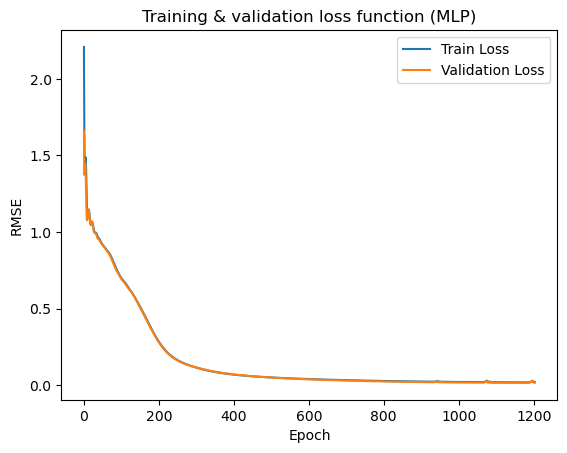

In [12]:
set_seed(42)

class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

# Funzione che restituisce il numero di parametri allenabili di una NN
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_mlp = MLP2()

# Definisco l'ottimizzatore e la funzione di perdita
optimizer = optim.Adam(model_mlp.parameters(), lr=0.01)
criterion = nn.MSELoss()

num_epochs = 5000
patience = 20
best_loss = float('inf')
trigger_times = 0
epochs = []
train_losses = []
val_losses = []
test_losses = []
accuracies = []

print('Addestramento della MLP')

start_time = time.time()

# Addestramento della MLP
for epoch in range(num_epochs):
    epochs.append(epoch)
    model_mlp.train()
    optimizer.zero_grad()
    output = model_mlp(training_data)
    # Calcolo della training loss
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model_mlp.eval()
    with torch.no_grad():
        val_output = model_mlp(validation_data)
        test_output = model_mlp(test_data)
        # Calcolo della validation loss
        val_loss = criterion(val_output, validation_label)
        val_losses.append(val_loss.item())
        # Calcolo della test loss
        test_loss = criterion(test_output, test_label)
        test_losses.append(test_loss.item())

    # Implemento l'early stopping
    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping all'epoca {epoch}")
            break
        
end_time = time.time()

# Salvo e stampo i parametri, il training time, e le loss function
parameters_mlp = count_parameters(model_mlp)
training_time_mlp = end_time - start_time
validation_loss_mlp = np.sqrt(val_losses[-1])
test_loss_mlp = np.sqrt(test_losses[-1])

print(f'Numero di parametri allenabili: {int(parameters_mlp)}')
print(f'Tempo di addestarmento: {training_time_mlp:.2f} s')
print(f'Validation loss: {validation_loss_mlp:.4f}')
print(f'Test loss: {test_loss_mlp:.4f}')

# Plotto l'andamento delle loss function
plt.figure()
plt.plot(epochs, np.sqrt(train_losses), label='Train Loss')
plt.plot(epochs, np.sqrt(val_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training & validation loss function (MLP)')
plt.legend()
plt.show()

train loss: 1.03e-02 | test loss: 1.10e-02 | reg: 1.27e+01 : 100%|██| 50/50 [00:17<00:00,  2.90it/s]

Addestramento della KAN
Numero di parametri allenabili: 75
Tempo di addestarmento: 17.27 s
Validation loss: 0.0110
Test loss: 0.0110


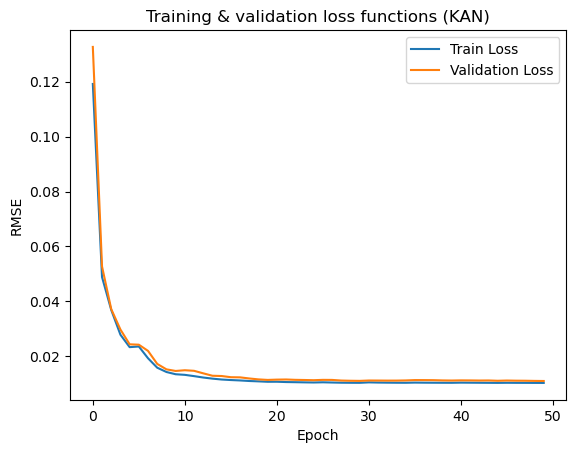

In [13]:
model_kan = KAN(width=[2,5,1], grid=5, k=3, seed=42)

start_time = time.time()

# Addestramento della KAN
steps = 50
results = model_kan.train(dataset, opt="LBFGS", steps=steps)

end_time = time.time()

# Salvo e stampo i parametri, il training time, la RMSE e l'accuratezza
parameters_kan = (2*5+5*1)*5
training_time_kan = end_time - start_time
validation_loss_kan = results['test_loss'][-1]
relative_error = torch.abs((model_kan(dataset['test_input']) - dataset['test_label']) / dataset['test_label'])
test_loss_kan = torch.sqrt(1/len(x_test) * torch.sum((model_kan(test_data) - test_label)**2))

print('Addestramento della KAN')
print(f'Numero di parametri allenabili: {int(parameters_kan)}')
print(f'Tempo di addestarmento: {training_time_kan:.2f} s')
print(f'Validation loss: {validation_loss_kan:.4f}')
print(f'Test loss: {test_loss_kan:.4f}')

# Plotto l'andamento delle loss function
plt.figure()
plt.plot(range(steps), results['train_loss'], label='Train Loss')
plt.plot(range(steps), results['test_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training & validation loss functions (KAN)')
plt.legend()
plt.show()

Anche qui plottiamo l'andamento della loss di test del modello MLP e paragoniamola con la loss di test del modello KAN. 

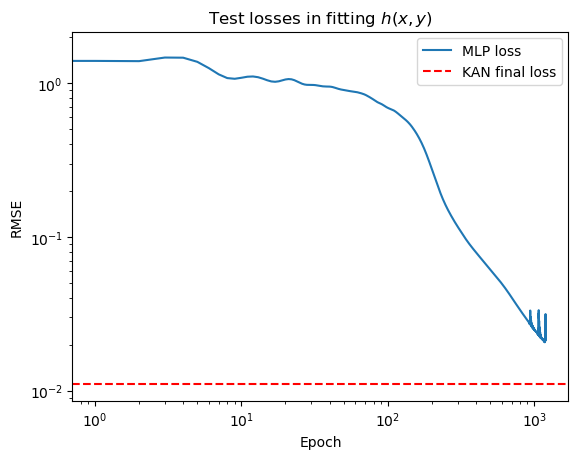

In [14]:
plt.figure()
plt.plot(epochs, np.sqrt(test_losses), label='MLP loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.axhline(test_loss_kan.detach().numpy(), color='red', linestyle='--', label='KAN final loss')
plt.title('Test losses in fitting $h(x,y)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('test_loss_h')
plt.show()

Notiamo che sorprendentemente il modello determinato dalla KAN riesce anche in questo caso a fittare ottimamente una funzione complessa $h$, pur mantenendo un numero basso di parametri allenabili.

Osserviamo invece che le predizioni di un modello MLP determinato da due hidden layer da 100 e 80 neuroni rispettivamente risultano meno precise di quelle del modello KAN, e sono determinate da un numero molto elevato di parametri allenabili. Il tempo di addestramento rimane l'unico fattore favorevole all'utilizzo delle MLP.

Possiamo quindi constatare che, più un problema di regressione diventa "complesso", più è conveniente utilizzare una KAN per fittare la funzione in esame: in generale tale modello risulta più accurato nelle predizioni, e più leggero nel numero di parametri allenabili.